In [84]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from scipy.stats import norm
from scipy.stats import truncnorm

In [3]:
def load_data(filename):
    with open(filename, 'r') as json_file:
        return json.load(json_file)

In [4]:
df_match_1 = pd.DataFrame(load_data('match_1.json'))
df_match_2 = pd.DataFrame(load_data('match_2.json'))

## Imbalanced Data

It is clear here that none of the given dataset are balanced which makes it harder while training

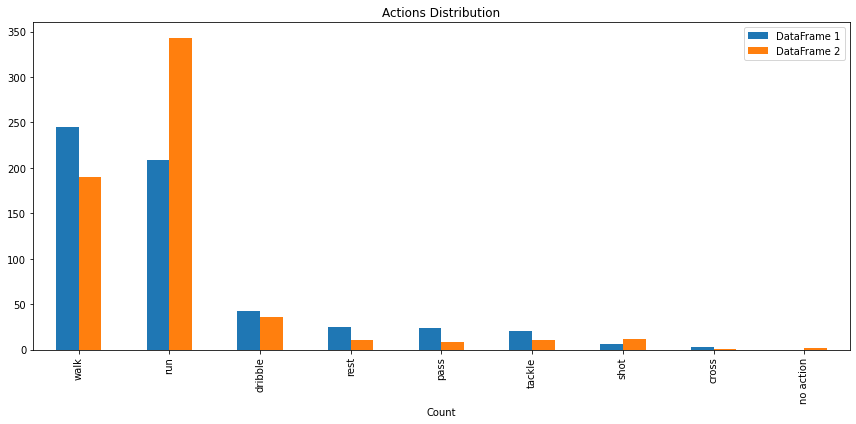

In [5]:
def label_dist(*dfs, label_column):
    label_counts = {}
    for i, df in enumerate(dfs):
        label_counts[f'DataFrame {i + 1}'] = df[label_column].value_counts()
    label_counts_df = pd.concat(label_counts, axis=1, sort=False).fillna(0)
    ax = label_counts_df.plot(kind='bar', figsize=(12, 6))
    ax.set_xlabel('Count')
    ax.set_title('Actions Distribution')
    plt.tight_layout()
    plt.show()
    
label_dist(df_match_1, df_match_2, label_column='label')

In [6]:
def feature_eng(*dfs):
    for i, df in enumerate(dfs):
        df['mean'] = df['norm'].apply(lambda x: np.mean(x))
        df['std'] = df['norm'].apply(lambda x: np.std(x))
        df['time'] = df['norm'].apply(lambda x: len(x)*1/50)
        df['sum'] = df['time'].cumsum()

feature_eng(df_match_1, df_match_2)

## Norm Distribution 

Below we will find all the norm distribution of the labels, it is clear the distribution between the actions are similar and overlapping 

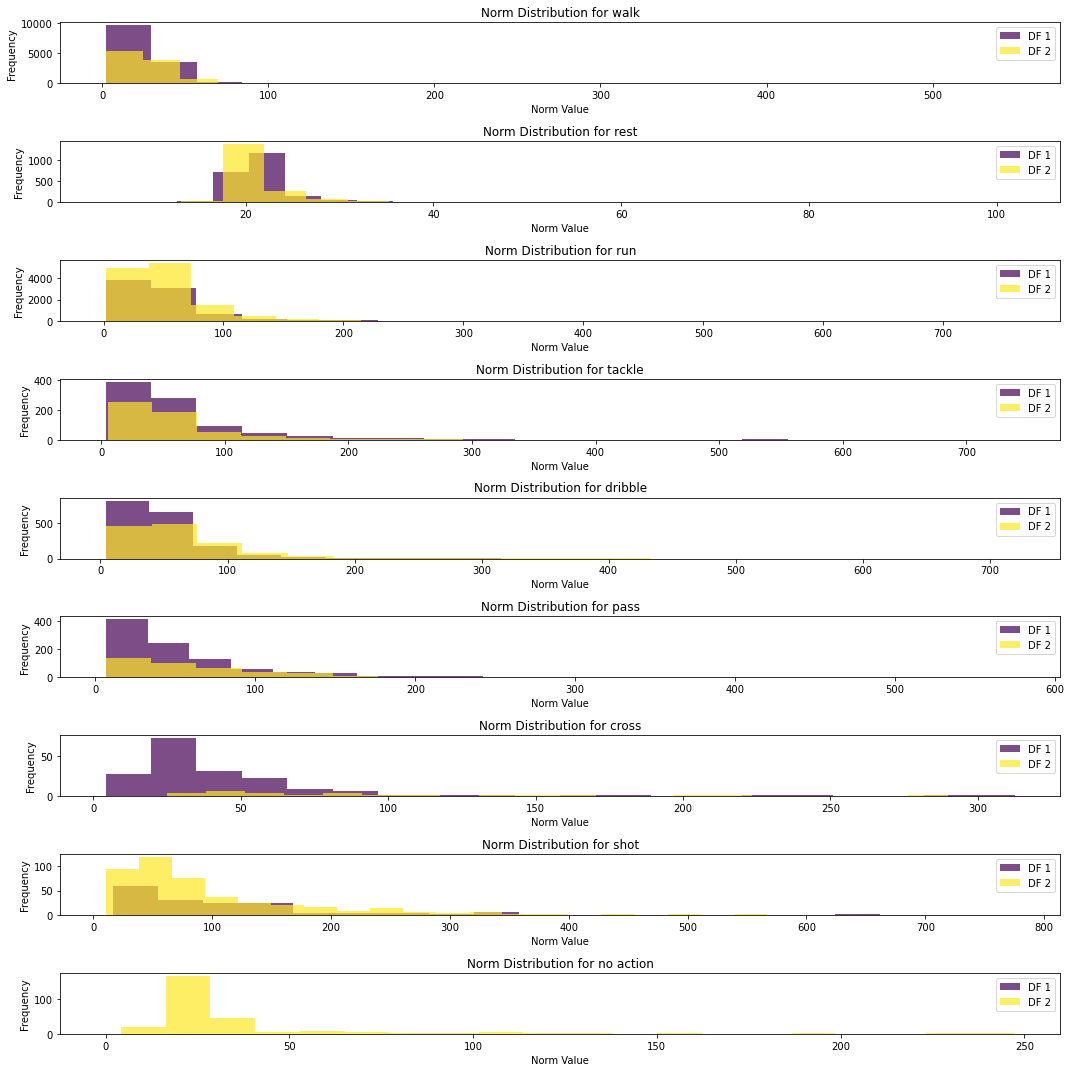

In [7]:
def plot_label_norms(*dfs, colors=None):
    # Create a separate subplot for each unique label
    unique_labels = pd.concat([df['label'] for df in dfs]).unique()
    
    # Determine the number of colors needed
    num_colors = len(dfs) if colors is None else len(colors)
    if colors is None:
        colors = plt.cm.viridis(np.linspace(0, 1, num_colors))
    
    # Adjust the figure size for larger graphs
    plt.figure(figsize=(15, 15))
    
    for i, label in enumerate(unique_labels, start=1):
        plt.subplot(len(unique_labels), 1, i)
        
        for j, df in enumerate(dfs):
            norms = df[df['label'] == label]['norm'].explode().values
            color = colors[j % num_colors]  # Cycle through colors if needed
            plt.hist(norms, bins=20, color=color, alpha=0.7, label=f'DF {j + 1}')
        
        plt.title(f'Norm Distribution for {label}')
        plt.xlabel('Norm Value')
        plt.ylabel('Frequency')
        plt.legend()
    
    plt.tight_layout()
    plt.show()


# Call the function with your DataFrames
plot_label_norms(df_match_1, df_match_2)

C:\Users\ralph\AppData\Local\Temp/ipykernel_22564/3810034062.py:6: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df_match_2, x='mean', hue='label', ax=axes[1])


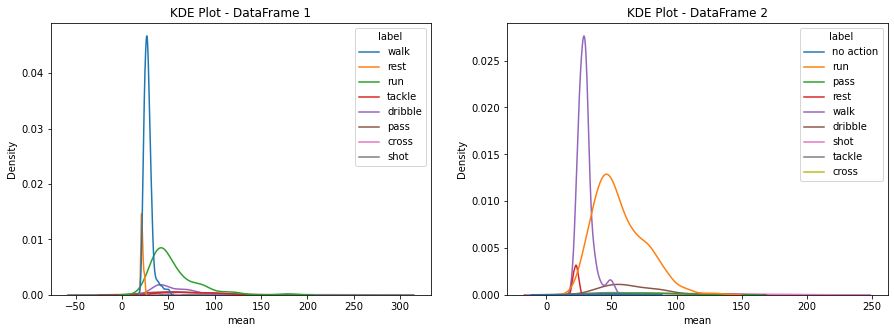

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.kdeplot(data=df_match_1, x='mean', hue='label', ax=axes[0])
axes[0].set_title('KDE Plot - DataFrame 1')

sns.kdeplot(data=df_match_2, x='mean', hue='label', ax=axes[1])
axes[1].set_title('KDE Plot - DataFrame 2')

plt.show()

C:\Users\ralph\AppData\Local\Temp/ipykernel_22564/1764004535.py:6: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df_match_2, x='time', hue='label', ax=axes[1])


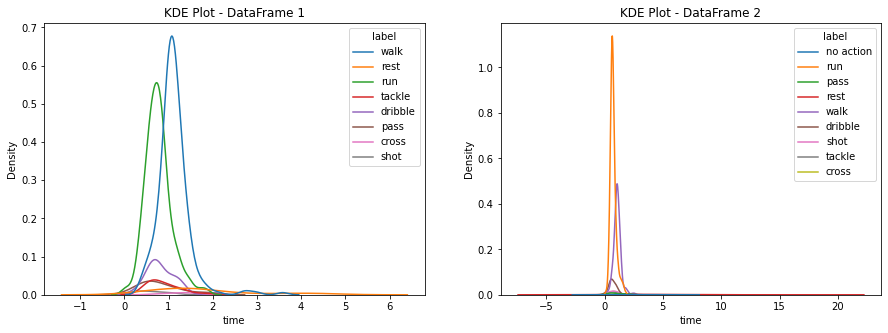

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.kdeplot(data=df_match_1, x='time', hue='label', ax=axes[0])
axes[0].set_title('KDE Plot - DataFrame 1')

sns.kdeplot(data=df_match_2, x='time', hue='label', ax=axes[1])
axes[1].set_title('KDE Plot - DataFrame 2')

plt.show()

the mean values for all the labels are overlaping which indicates that there isn't much difference between the distribution of the values

In [10]:
def outliers(*dfs):
    for i, df in enumerate(dfs):
        filtered_df = df[df['norm'].apply(lambda x: len(x) > 150 or len(x) < 6)]
        outlier_count = len(filtered_df)
        print(f"For DataFrame {i+1}, there are {outlier_count} outliers.")

In [11]:
outliers(df_match_1, df_match_2)

For DataFrame 1, there are 9 outliers.
For DataFrame 2, there are 6 outliers.


## Norm Distribution

We can see from the images below that the norm distribution of all the label isn't changing over time

<Figure size 1080x432 with 0 Axes>

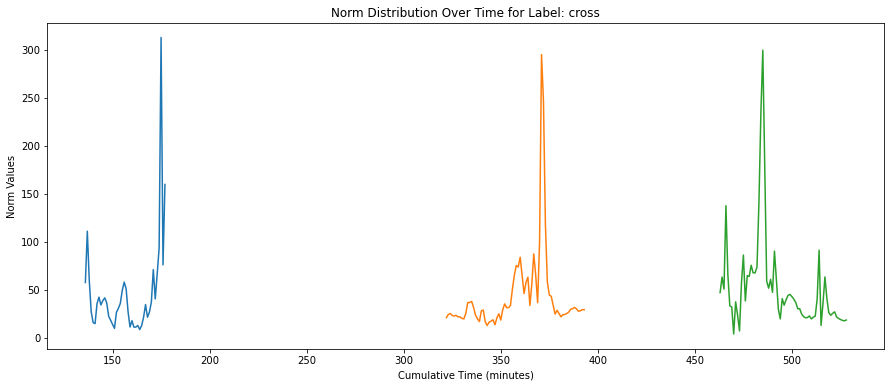

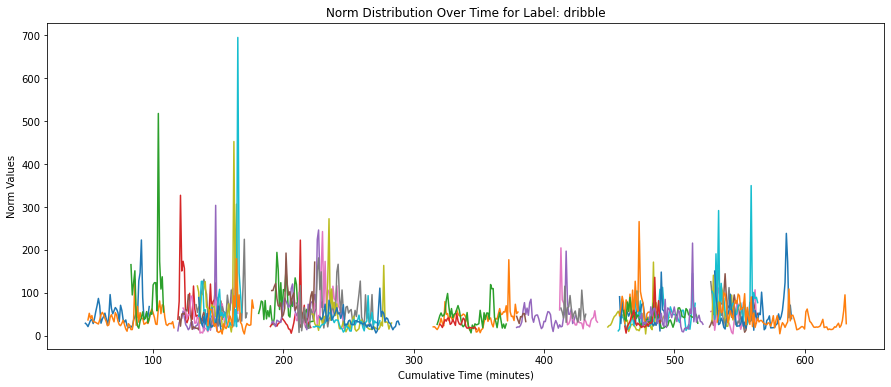

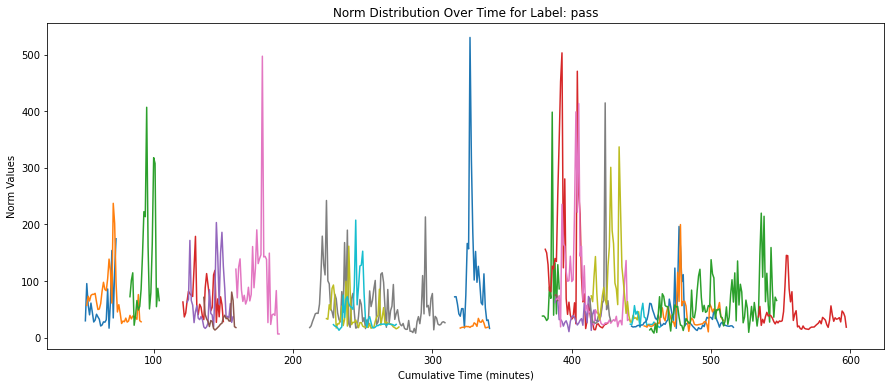

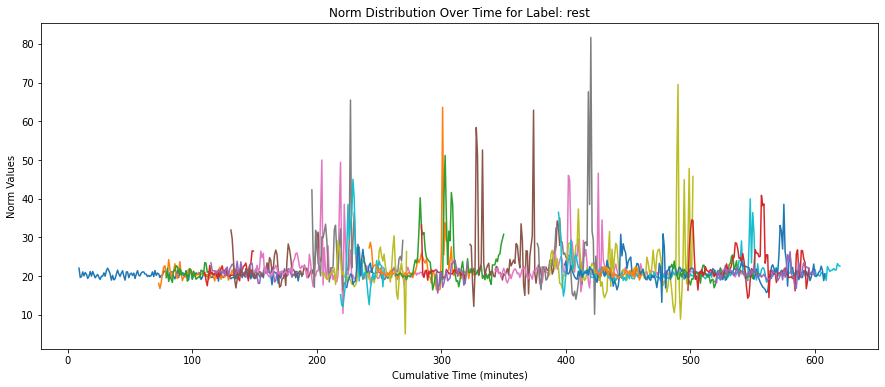

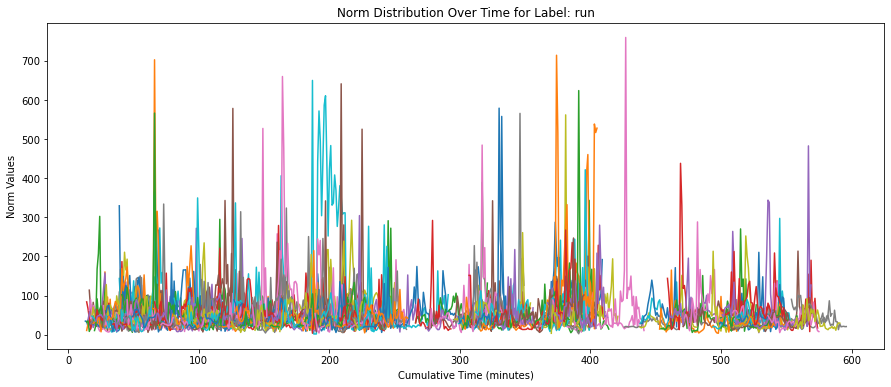

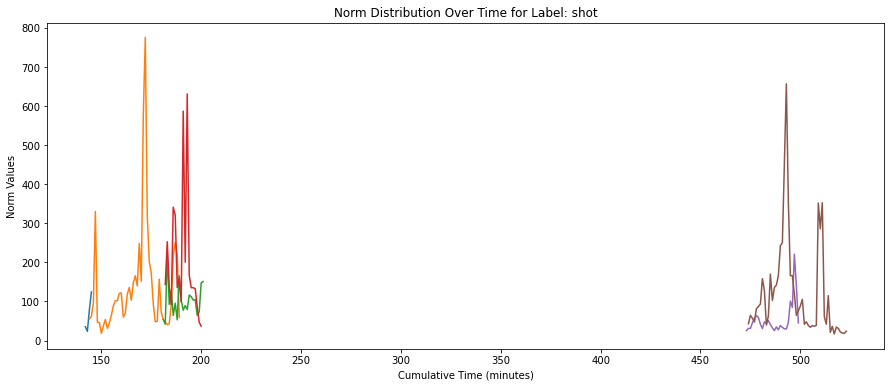

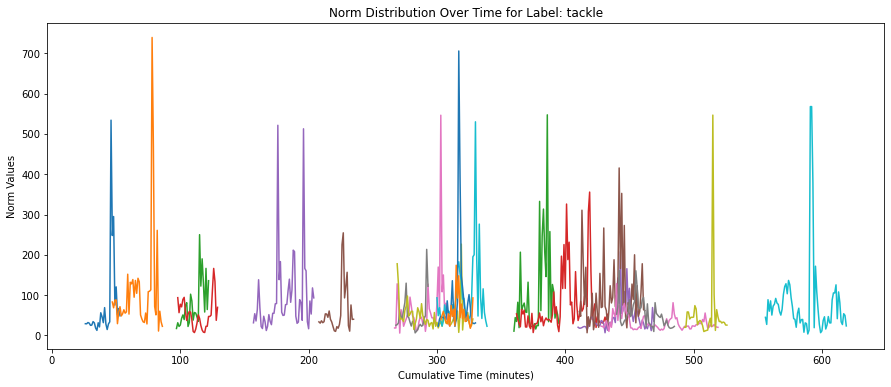

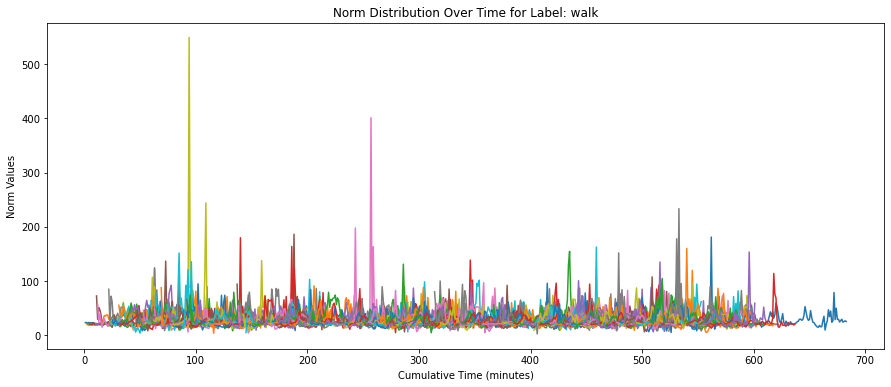

In [136]:
grouped = df_match_1.groupby('label')

# Set a larger figure size
plt.figure(figsize=(15, 6))

# Create a separate plot for each label
for label, group_data in grouped:
    fig, ax = plt.subplots(figsize=(15, 6))  # Adjust the figure size here
    
    # Iterate over rows in the group
    for index, row in group_data.iterrows():
        norm_values = row['norm']
        cumulative_time = int(row['sum'])
    
        # Plot the norm values against cumulative time
        ax.plot(range(cumulative_time, cumulative_time + len(norm_values)), norm_values, label=f"{label} - Time {cumulative_time}")

    # Set axis labels and title
    ax.set_xlabel('Cumulative Time (minutes)')
    ax.set_ylabel('Norm Values')
    ax.set_title(f'Norm Distribution Over Time for Label: {label}')

    # Show the plot for this label
    plt.show()

## Generating the mean time distrubtion

Here I generated a distribution of each action and during the generation I pick a random value from the distribution for a specific action

In [85]:
min_time = 0.1
max_time = 3

distributions = {}

for label, group in df_match_1.groupby('label'):
    mean_time = group['time'].mean()
    std_time = group['time'].std()
    
    # Calculate the lower and upper bounds for truncation
    a = (min_time - mean_time) / std_time
    b = (max_time - mean_time) / std_time
    
    # Create a truncated normal distribution for the label
    distributions[label] = truncnorm(a, b, loc=mean_time, scale=std_time)

In [184]:
joblib.dump(distributions, 'label_distribution.pkl')

['label_distribution.pkl']